## Modeling

In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras import layers
import keras
from keras.models import Sequential
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [9]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in tqdm(genres):
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)
    for filename in tqdm(os.listdir(f'/Volumes/S190813/Coding/genres/{g}')):
        songname = f'/Volumes/S190813/Coding/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

%|██▏       | 22/100 [00:06<00:18,  4.14it/s]
100%|██████████| 10/10 [03:57<00:00, 24.03s/it]


<Figure size 576x576 with 0 Axes>

In [10]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [13]:
file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in tqdm(genres):
    for filename in tqdm(os.listdir(f'/Volumes/S190813/Coding/genres/{g}')):
        songname = f'/Volumes/S190813/Coding/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        rmse = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

%|██▏       | 22/100 [00:10<00:39,  1.98it/s]
100%|██████████| 10/10 [08:17<00:00, 48.97s/it]


In [2]:
data = pd.read_csv('dataset.csv')
data.head()# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)#Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)#Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))#Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               6912      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 48,714
Trainable params: 48,714
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
800/800 [==============================] - 0s 362us/step - loss: 2.1679 - accuracy: 0.1900
Epoch 2/100
800/800 [==============================] - 0s 45us/step - loss: 1.8172 - accuracy: 0.3988
Epoch 3/100
800/800 [==============================] - 0s 100us/step - loss: 1.5850 - accuracy: 0.4300
Epoch 4/100
800/800 [==============================] - 0s 57us/step - loss: 1.4165 - accuracy: 0.4938
Epoch 5/100
800/800 [==============================] - 0s 68us/step - loss: 1.2952 - accuracy: 0.5663
Epoch 6/100
800/800 [==============================] - 0s 53us/step - loss: 1.2048 - accuracy: 0.5675
Epoch 7/100
800/800 [==============================] - 0s 64us/step - loss: 1.1210 - accuracy: 0.6275
Epoch 8/100
800/800 [==============================] - 0s 51us/step - loss: 1.0428 - accuracy: 0.6675
Epoch 9/100
800/800 [==============================] - 0s 35us/step - loss: 0.9751 - accuracy: 0.6938
Epoch 10/100
800/800 [==============================] - 0s 52us/step - loss: 0.9

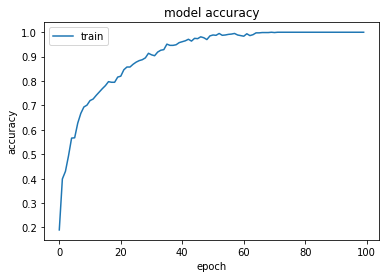

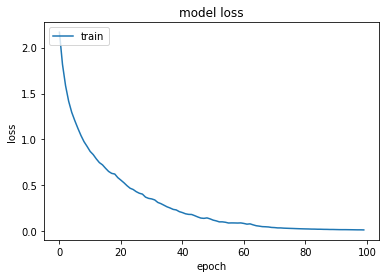

In [5]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


accuracy: 71.00%


In [13]:
from keras.models import load_model
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test[:3])
print('predictions shape:', predictions.shape)

model.save('ANN_genre_clf.sav')
print('model saved')


# Evaluate on test data
200/200 [==============================] - 0s 47us/step
test loss, test acc: [1.6240698099136353, 0.7099999785423279]

# Generate predictions for 3 samples
predictions shape: (3, 10)
model saved


dict_keys(['loss', 'accuracy'])


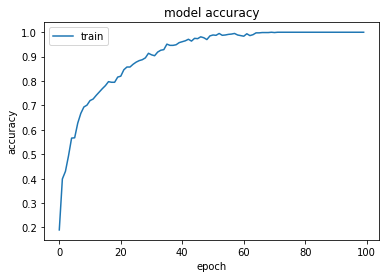

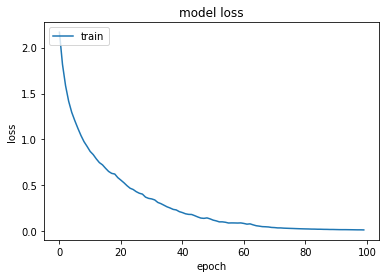

In [14]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('ANN_training_accuracy')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('ANN_training_loss')
plt.show()

In [3]:
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               6912      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 50,474
Trainable params: 50,474
Non-trainable params: 0
_________________________________________________________________


Epoch 609/800
800/800 [==============================] - 0s 45us/step - loss: 0.0020 - accuracy: 0.9987
Epoch 610/800
800/800 [==============================] - 0s 50us/step - loss: 0.0019 - accuracy: 0.9987
Epoch 611/800
800/800 [==============================] - 0s 51us/step - loss: 0.0021 - accuracy: 0.9987
Epoch 612/800
800/800 [==============================] - 0s 44us/step - loss: 0.0021 - accuracy: 0.9987
Epoch 613/800
800/800 [==============================] - 0s 47us/step - loss: 0.0021 - accuracy: 0.9987
Epoch 614/800
800/800 [==============================] - 0s 41us/step - loss: 0.0027 - accuracy: 0.9987
Epoch 615/800
800/800 [==============================] - 0s 56us/step - loss: 0.0031 - accuracy: 0.9987
Epoch 616/800
800/800 [==============================] - 0s 49us/step - loss: 0.0028 - accuracy: 0.9987
Epoch 617/800
800/800 [==============================] - 0s 78us/step - loss: 0.0021 - accuracy: 0.9987
Epoch 618/800
800/800 [==============================] - 0s 62us

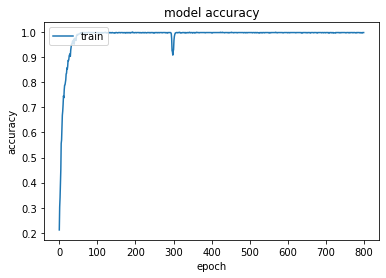

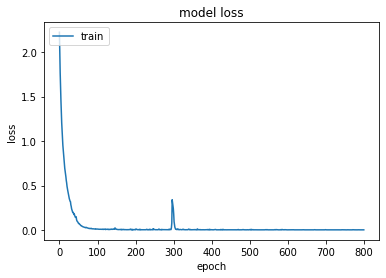

In [4]:
history = model.fit(X_train,
                    y_train,
                    epochs=800,
                    batch_size=128)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [5]:
# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 66.00%


In [6]:
from keras.models import load_model
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test[:3])
print('predictions shape:', predictions.shape)

model.save('ANN_2_genre_clf.sav')
print('model saved')


# Evaluate on test data
200/200 [==============================] - 0s 98us/step
test loss, test acc: [3.1222442054748534, 0.6600000262260437]

# Generate predictions for 3 samples
predictions shape: (3, 10)
model saved


In [7]:
# Save the weights
model.save_weights('ANN_2_model_weights.h5')

# Save the model architecture
with open('ANN_model_2_architecture.json', 'w') as f:
    f.write(model.to_json())